<a href="https://colab.research.google.com/github/sunandhini96/TSAI_ERAV1/blob/main/Session_17/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/sunandhini96/TSAI_ERAV1.git

Cloning into 'TSAI_ERAV1'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 526 (delta 42), reused 24 (delta 24), pack-reused 472
Receiving objects: 100% (526/526), 13.67 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (234/234), done.


In [3]:
import torch

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
cd /content/TSAI_ERAV1/Session_17

/content/TSAI_ERAV1/Session_17


In [6]:
from datamodules.vit_datamodule import create_dataloaders

In [7]:
import os
from transformer import *
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
image_path = "/content/drive/MyDrive/sunandini/pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"


In [9]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ed390b1e4d0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

In [12]:
vit = Transformer(n_heads=8, block_size=16, num_layers=12,embedding_dim=768, num_classes=3,algorithm="VIT")

In [ ]:
!pip install torchinfo

In [16]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
Transformer (Transformer)                                              [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                     [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                                [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                               [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                     [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderB

In [18]:
from super_repo import data_setup, engine, utils
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5763 | train_acc: 0.2656 | test_loss: 1.4659 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4693 | train_acc: 0.4062 | test_loss: 1.8838 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.4506 | train_acc: 0.3945 | test_loss: 1.4386 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1231 | train_acc: 0.4336 | test_loss: 2.0086 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1948 | train_acc: 0.3984 | test_loss: 2.1554 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1894 | train_acc: 0.3086 | test_loss: 1.0383 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1982 | train_acc: 0.3008 | test_loss: 1.0812 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.2131 | train_acc: 0.3008 | test_loss: 1.0586 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2050 | train_acc: 0.2812 | test_loss: 1.1567 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.2706 | train_acc: 0.2930 | test_loss: 1.1578 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.1700 | train_acc: 0.3672 | test_loss: 1.0072 | test_acc: 0.5417
Epoch: 12 | train_l

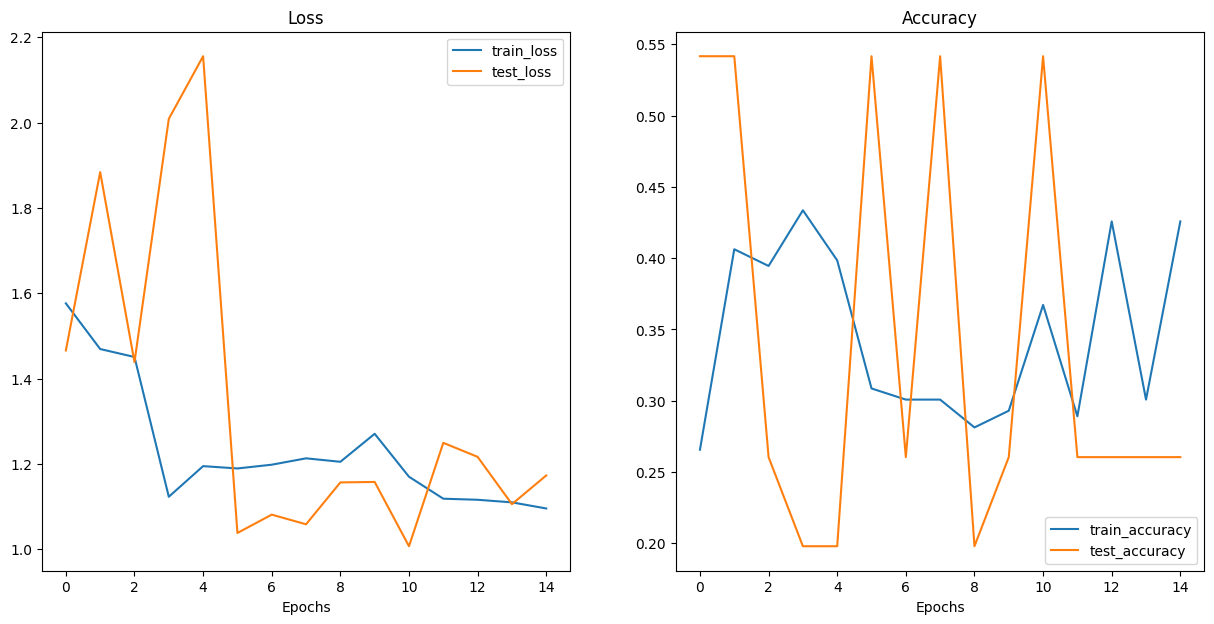

In [19]:
from super_repo.utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [21]:
# Save the model
utils.save_model(model=vit,
                 target_dir="/content/drive/MyDrive/sunandini/models",
                 model_name="vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: /content/drive/MyDrive/sunandini/models/vit_feature_extractor_pizza_steak_sushi.pth


Downloading...


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


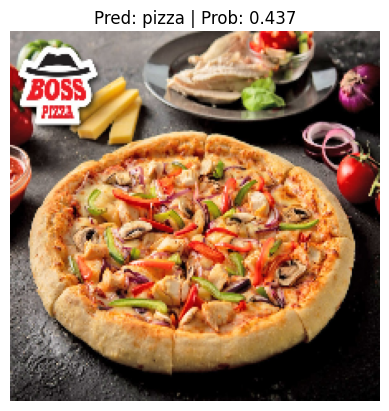

In [24]:
import requests

with open("download.jpeg", "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://www.boss-pizza.co.uk/site/assets/images/uploads/2_3_5c232a9d83be_o.jpg")
    print(f"Downloading...")
    f.write(request.content)

# Predict on custom image
utils.pred_and_plot_image(model=vit,
                    image_path="download.jpeg",
                    transform=transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    class_names=class_names)